# <p style="text-align: center;"> PROJECT 1</p>

### **Libraries**

In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
%matplotlib inline
from PIL import Image # Install Pillow -> conda install anaconda::pillow or pip install pillow
import os
from skimage.io import  imread, imshow # Install scikit-image -> conda install scikit-image or pip install scikit-image
import torch
import torch.nn as nn
import re
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score
from sklearn import preprocessing
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV

c:\Users\davic\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### **Load Images Dataset**

In [2]:
# Get the Image Dataset Paths
train_dataset_path = 'data-students/TRAIN/'
test_dataset_path = 'data-students/TEST'

In [3]:
IMG_WIDTH = 75
IMG_HEIGHT = 75
BATCH_SIZE = 64

In [4]:
# Load the training dataset. Via DataGenerators
transform = transforms.Compose([transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),transforms.ToTensor()]) # rezise the image to have the right shape and transforms to tensor 

train_datagen = datasets.ImageFolder(root=train_dataset_path, transform=transform) # get the dataset
train_dataset_loader = DataLoader(train_datagen, batch_size=BATCH_SIZE, shuffle=True) # put the dataset in batches and will shuffle it

In [5]:
# Load the test dataset.
class TestDataset(Dataset):
    def get_int(self, text):
        return [int(c) if c.isdigit() else c for c in re.split('(\d+)', text)]
    
    def __init__(self, images_folder, transform=None): # initiate the dataset
        self.images_folder = images_folder
        self.image_files = [f for f in os.listdir(images_folder) if os.path.isfile(os.path.join(images_folder, f))]
        self.image_files.sort(key=self.get_int)
        self.transform = transform

    def __len__(self): # amount of objects in the data
        return len(self.image_files)

    def __getitem__(self, idx): # get the images
        img_name = os.path.join(self.images_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

inference_dataset = TestDataset(images_folder=test_dataset_path, transform=transform)

test_dataset_loader_K = DataLoader(inference_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
# Get the Label Mappings
labels = {value: key for key, value in train_datagen.class_to_idx.items()}
print(labels)
the_real_labels = {}
with open("data-students/labels.csv","r") as label_f:
    for line in label_f.readlines()[1:]:
        label_value, label_description = line.strip().split(";")
        the_real_labels[int(label_value)] = label_description 

print(the_real_labels)

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value} - {the_real_labels[int(value)]}")
the_labels_map = {key: value for key, value in train_datagen.class_to_idx.items()}
print(len(labels))

{0: '12', 1: '13', 2: '24', 3: '37', 4: '38', 5: '39', 6: '44', 7: '50', 8: '6'}


{6: 'Speed limit (70km/h)', 12: 'Dont Go Left or Right', 13: 'Dont Go Right', 24: 'Go Right', 37: 'Children crossing', 38: 'Dangerous curve to the right', 39: 'Dangerous curve to the left', 44: 'Go left or straight', 50: 'Fences'}
Label Mappings for classes present in the training and validation datasets

0 : 12 - Dont Go Left or Right
1 : 13 - Dont Go Right
2 : 24 - Go Right
3 : 37 - Children crossing
4 : 38 - Dangerous curve to the right
5 : 39 - Dangerous curve to the left
6 : 44 - Go left or straight
7 : 50 - Fences
8 : 6 - Speed limit (70km/h)
9


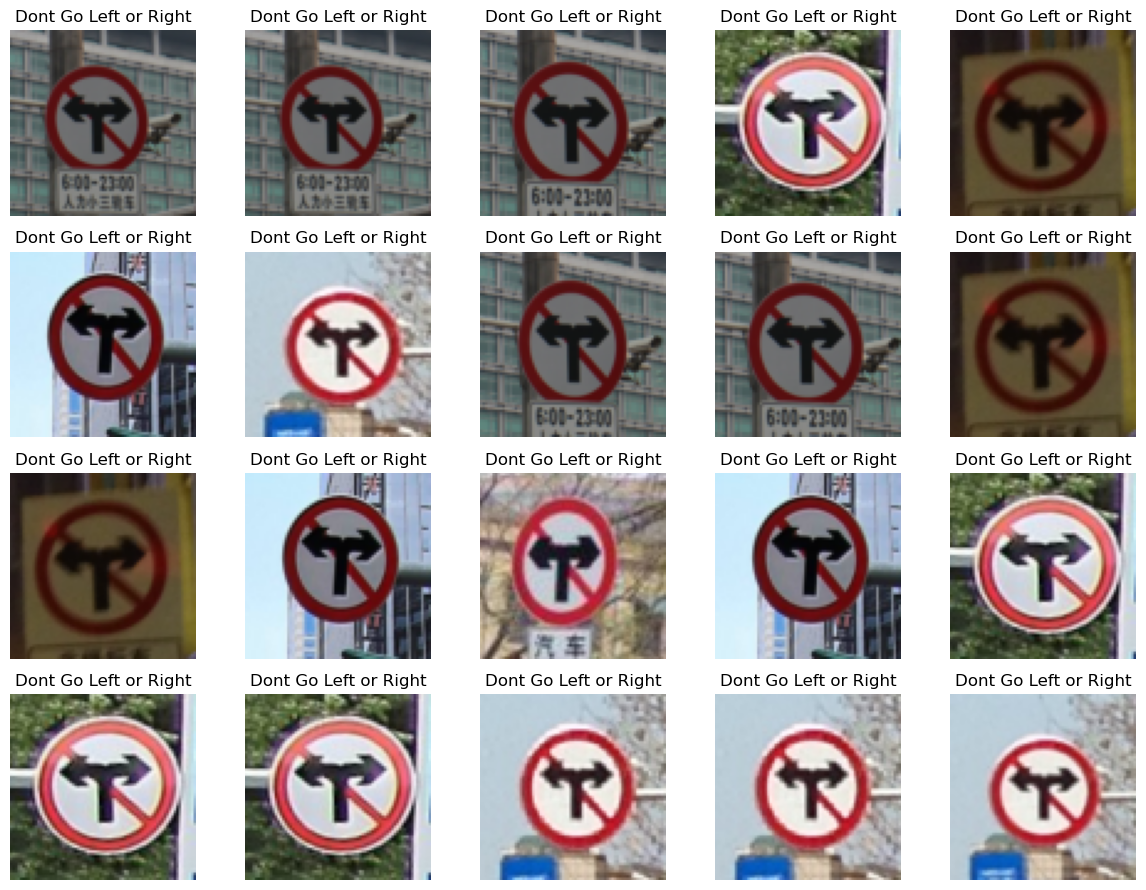

In [7]:
# Plotting Sample Training Images
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(12, 9))
dataiter = iter(train_datagen)
idx = 0

for i in range(4):
    for j in range(5):
        images, l = next(dataiter)
        img = images
        label = the_real_labels[int(labels[l])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(img.permute(1,2,0))
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.show()

### **Preliminary Steps**

i - Check the range of values of the data set

In [8]:
def max_min_values(dataset, type=0):
    max_value = float('-inf')
    min_value = float('inf')

    for batch in dataset:
        if type==0:
            images, _ = batch
        else:
            images = batch
        max_batch = images.max()
        min_batch = images.min()
        if max_batch > max_value:
            max_value = max_batch
        if min_batch < min_value:
            min_value = min_batch
        
    print("Maximum pixel value:", max_value)
    print("Minimum pixel value:", min_value)

In [9]:
# Check if the dataset needs to be normalized
print("Train dataset")
max_min_values(train_datagen) # train
print("Test dataset")
max_min_values(test_dataset_loader_K,1) # test

Train dataset
Maximum pixel value: tensor(1.)
Minimum pixel value: tensor(0.)
Test dataset
Maximum pixel value: tensor(1.)
Minimum pixel value: tensor(0.)


ii - Visualization of the distribution of each class

In [10]:
# Plot random images from the dataset
def plot_images(x,y,half=False):
  labels = {0:'12',1:'13',2:'24',3:'37',4:'38',5:'39',6:'44',7:'50',8:'6'}
  
  fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(12, 9))
  
  for i in range(4):
    for j in range(5):
      ind = random.randint(0, np.size(x, 0)-1)
      img = x[ind]
      
      label = the_real_labels[int(labels[y[ind].item()])]
      img_shape = img.shape  # Get the shape of the image

      img = np.transpose(img, (1, 2, 0)) # Transpose dimensions to (height, width, channels)
      
      ax[i, j].set_title(f"{label}")
      ax[i, j].imshow(img)
      ax[i, j].axis("off")
  
  plt.tight_layout()
  plt.show()

In [11]:
def get_class_distribution(dataset, ind=1):
    
    labels = {0:'12',1:'13',2:'24',3:'37',4:'38',5:'39',6:'44',7:'50',8:'6'}
    
    if (ind == 1):
        count_dict = {k:0 for k,v in dataset.class_to_idx.items()} # initialise dictionary
    elif (ind == 2):
        count_dict = {k:0 for k in np.unique(dataset)}
        count_dict = {labels[k]: v for k, v in count_dict.items()} # Convert class indices to corresponding labels
    else:
        count_dict = {label: 0 for label in dataset.dataset.class_to_idx.values()}
    
    #print(count_dict)
    if(ind != 2):
        for input, label in dataset:
            if (ind == 1):
                count_dict[labels[label]] += 1
            else:
                count_dict[label] += 1
    else:
        for label in dataset:
            count_dict[labels[label]] += 1
        
    if (ind==0):
        # Convert class indices to corresponding labels
        count_dict = {labels[k]: v for k, v in count_dict.items()}
    
    print(count_dict)        
    return count_dict

In [12]:
def plot_distribution(dataset, ind=1):
    # visualize the  class distribution
    if(ind == 1):
        plt.figure(figsize=(5, 5))
        sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(dataset,ind)]).melt(), 
                    x = "variable", y="value", hue="variable").set_title('Class Distribution of the dataset')
    elif (ind == 2):
        plt.figure(figsize=(5, 5))
        sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(dataset,ind)]).melt(), 
                    x = "variable", y="value", hue="variable").set_title('Class Distribution of the dataset')
    else:
        fig, axes = plt.subplots(1, 3, figsize=(10, 5)) # Create subplots
        # Plot train set distribution
        sns.barplot(data=pd.DataFrame.from_dict([get_class_distribution(dataset[0],ind)]).melt(),
                    x="variable", y="value", hue="variable", ax=axes[0]).set_title('Train Set')
        
        # Plot validation set distribution
        sns.barplot(data=pd.DataFrame.from_dict([get_class_distribution(dataset[1],ind)]).melt(),
                    x="variable", y="value", hue="variable", ax=axes[1]).set_title('Validation Set')
        
        # Plot test set distribution
        sns.barplot(data=pd.DataFrame.from_dict([get_class_distribution(dataset[2],ind)]).melt(),
                    x="variable", y="value", hue="variable", ax=axes[2]).set_title('Test Set')
        
        plt.suptitle('Datasets Class Distributions')
        plt.tight_layout()
        plt.show()

{'12': 96, '13': 36, '24': 100, '37': 58, '38': 30, '39': 34, '44': 30, '50': 56, '6': 78}


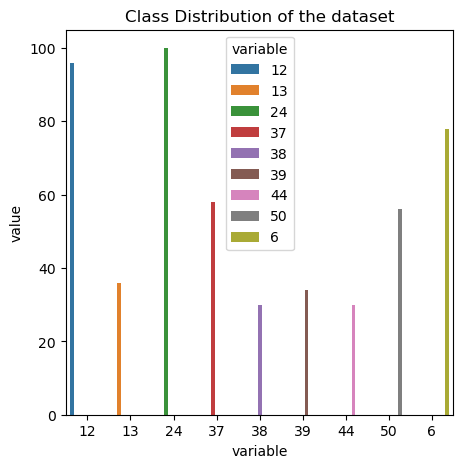

In [13]:
plot_distribution(train_datagen)

In [14]:
# We can see that the data is imbalanced in some classes there are lot of entries and in other there are little entries, that can lead to biased towards the majority class.

# Solutions: Data Augmentation (applying transformations in the images such as rotation, flipping, scaling and cropping)
#            Class Weighting (Giving different weights to the loss function, more weights to the minority classes)
#            Dropout / Undersampling or Oversampling
#            Ensemble Methods

In [15]:
# We can test 2 approaches to compare the results of the models
# Data Oversampling and Class Weighting

In [16]:
# Data Oversampling
def data_oversampling(X,y):
    # Instantiate the RandomOversampler
    ros = RandomOverSampler(random_state=42)

    # Resample the dataset
    X_res, y_res = ros.fit_resample(X, y)
    
    return X_res, y_res

In [17]:
# Class Weighting
def get_weights(y,debug=False):
    class_counts = torch.bincount(y.clone().detach()) # Count the number of samples in each class

    # Calculate the class weights
    total_samples = float(len(y))
    classes_weights = total_samples / (class_counts.float() + 1e-5)  # Add a small epsilon to avoid division by zero (if the class has zero samples)

    if debug:
        print(classes_weights)

    return classes_weights

iii -  Splitting the dataset into Train Validation Test sets

In [18]:
# Split the dataset in a 80/10/10 Ratio
train_size = int(0.8*len(train_datagen))
validation_size = int(0.1*len(train_datagen))
test_size = len(train_datagen) - train_size - validation_size

# Random_split
train_dataset, validation_dataset, test_dataset = random_split(train_datagen, [train_size,validation_size,test_size])

In [19]:
# Creating data loaders for train and validation
train_dataset_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataset_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

{'12': 74, '13': 25, '24': 82, '37': 47, '38': 21, '39': 28, '44': 26, '50': 51, '6': 60}
{'12': 11, '13': 5, '24': 9, '37': 5, '38': 5, '39': 4, '44': 3, '50': 3, '6': 6}
{'12': 11, '13': 6, '24': 9, '37': 6, '38': 4, '39': 2, '44': 1, '50': 2, '6': 12}


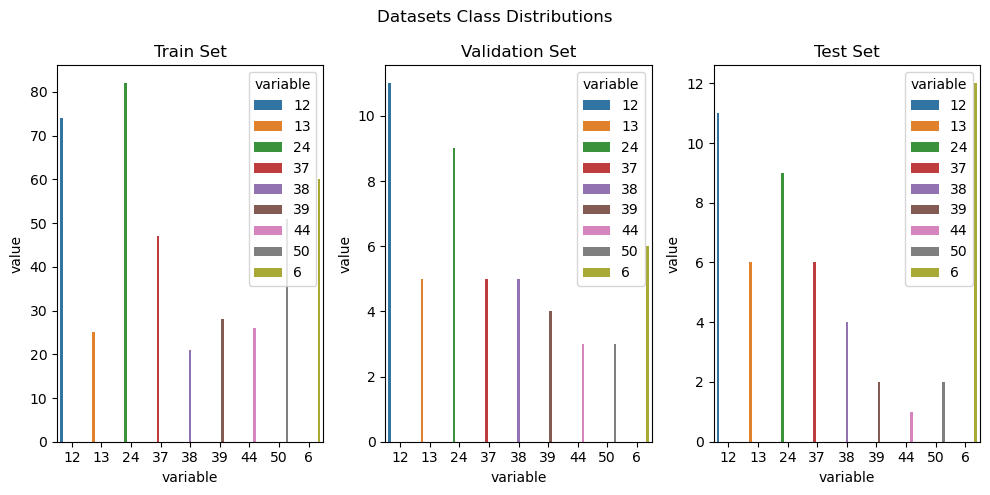

In [20]:
# Checks the distribution for each dataset
plot_distribution([train_dataset, validation_dataset, test_dataset], 0)

In [21]:
# Split the images from the labels in the dataset
def get_x_y(dataset):
    # list to store the images and labels
    x = []
    y = []

    # Iterate over the input to store them into X and Y
    for images, labels in dataset:
        x.append(images)
        y.append(labels)

    # Concatenate the list and transforms into a tensor
    x = torch.cat(x, dim=0)
    y = torch.cat(y, dim=0)

    return x, y

In [22]:
X_train, y_train = get_x_y(train_dataset_loader)
X_val, y_val = get_x_y(validation_dataset_loader)
X_test, y_test = get_x_y(test_dataset_loader)

In [23]:
# DATA OVERSAMPLING #
# flatten the image
X_train_fl = X_train.reshape(X_train.shape[0], -1) # Converts the 3D images to 1D vectors)

# Data Oversampling
X_train_data_ovs, y_train_data_ovs = data_oversampling(X_train_fl,y_train)

# Reshape the data
X_train_data_ovs = X_train_data_ovs.reshape(-1, 3, IMG_HEIGHT, IMG_WIDTH)  # Reshape to original format

print("Oversampling \n- Before:",len(X_train),"\n- After:", len(X_train_data_ovs))

Oversampling 
- Before: 414 
- After: 738


{'12': 82, '13': 82, '24': 82, '37': 82, '38': 82, '39': 82, '44': 82, '50': 82, '6': 82}


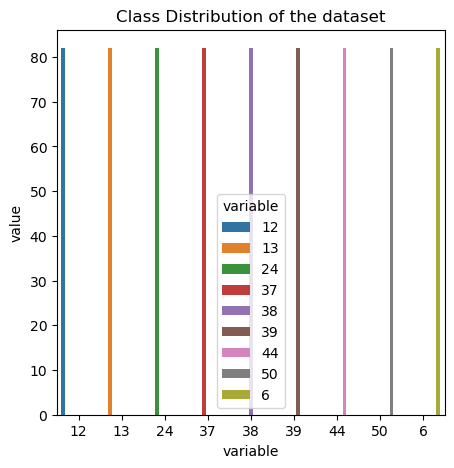

In [24]:
plot_distribution(y_train_data_ovs,2)

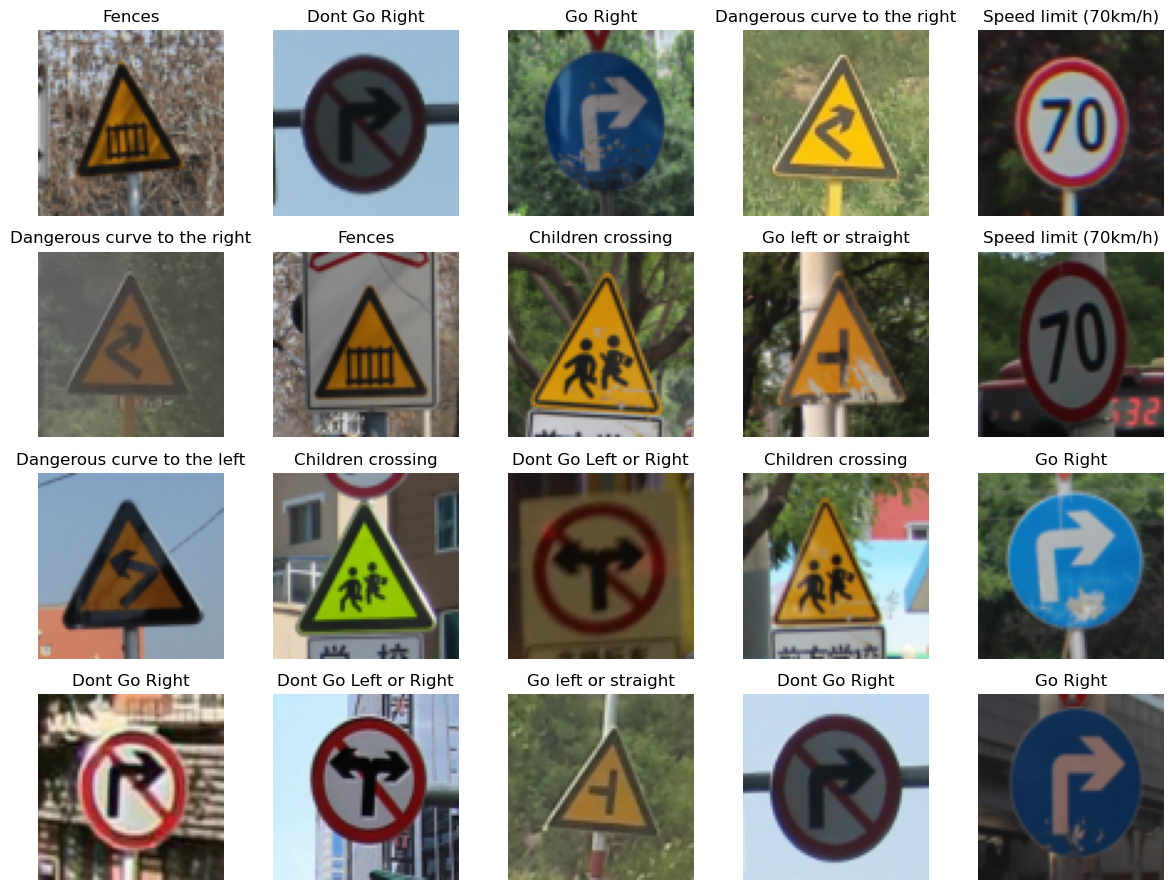

In [25]:
plot_images(X_train_data_ovs,y_train_data_ovs)

### **5. Models**

In [26]:
# Using manual seed to make sure that anyone who re-runs your code will get the exact same outputs. 
torch.manual_seed(42) 

In [27]:
# Check a better way to train the model instead of the CPU
if torch.backends.mps.is_available():
    device = torch.device("mps") # new macbooks
elif torch.cuda.is_available():    
    device = torch.device("cuda") # NVIDIA CUDA
else:
    device = torch.device("cpu")

###### **Model Evatuation Function** 

In [28]:
# accuracy is weak for unbalanced datasets
# overfitting you are remembering the cases of the training data instead of learning from it
def evaluate_network(net, X, y, to_device=True):
    # Set the model to evaluation mode
    net.eval()
    if to_device:
        X = X.to(device)
        net = net.to(device)

    # Run the model on the test data
    with torch.no_grad():
        outputs = net(X)
        _, predicted = torch.max(outputs.data, 1)

    # Convert tensors to numpy arrays
    if to_device:
        predicted = predicted.to("cpu")
    predicted_np = predicted.numpy()
    test_target_np = y.numpy()

    # Compute confusion matrix and F1 score
    conf_mat = confusion_matrix(test_target_np, predicted_np)
    f1 = f1_score(test_target_np, predicted_np, average='weighted')
    accuracy = accuracy_score(test_target_np, predicted_np)
    precision = precision_score(test_target_np, predicted_np, average='weighted')

    print('Confusion Matrix:\n', conf_mat)
    print('F1 Score: ', f1)
    print('Accuracy: ', accuracy)
    print('Precison: ', precision)
    

###### **Train Function** 

In [29]:
def fit(X_train, y_train, X_val, y_val, nn, criterion, optimizer, n_epochs, to_device=True, batch_size=32, ClassWeights=False, patience=5):
    #send everything to the device (ideally a GPU)
    if to_device:
        nn = nn.to(device)
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        
    if(ClassWeights == True): # In the case of Class Weighting
        class_weights = get_weights(y_train)

    # Train the network
    train_loss_values = []
    val_loss_values = []
    train_acc_values = []
    val_acc_values = []
    
    # Variables to help with the early stopping
    best_val_loss = float('inf')   
    best_model = None              
    epochs_no_improve = 0          # No of epochs with no improvement

    
    for epoch in range(n_epochs):
        nn.train()
        
        train_loss = 0
        train_acc = 0
        n = 0
        for i in range(0, X_train.size(0), batch_size): # the objective of the use of batch is to always improve the classifier in some sets of data
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # Forward pass
            outputs = nn(X_batch)
            
            _, predicted = torch.max(outputs.data, 1)
                        
            loss = criterion(outputs, y_batch)
            accuracy = accuracy_score(y_batch, predicted)
                        
            if ClassWeights == True: # Manually apply class weights
                loss = torch.mean(loss * class_weights)
                
            train_loss += loss.item() 
            train_acc += accuracy          
            
            # Backward and optimize - to improve the weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            n+=1
                
        # Calculate the loss and acc values for the validation set
        nn.eval()
        outputs_val = nn(X_val) 
        _, predicted_val = torch.max(outputs_val.data, 1)
                        
        # Loss function
        loss_val = criterion(outputs_val, y_val)
            
        # Accuracy
        accuracy_val = accuracy_score(y_val, predicted_val)
            
        # calculate loss and accuracy
        val_loss = loss_val.item()
        val_acc = accuracy_val
            
        # Check for early stopping
        if val_loss < best_val_loss: 
            best_val_loss = val_loss # updates the best value
            best_model = nn.state_dict() # save the current model weights
            epochs_no_improve = 0 # reset the counter
        else:
            epochs_no_improve += 1 # case of no improvement
            
        print ('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}, Train Acc: {:.4f}, Val Acc: {:.4f}'.format(epoch+1, n_epochs, train_loss/n, val_loss, train_acc/n, val_acc))
            
        if epochs_no_improve >= patience: # if the patience value is reached, it stops the training
            print("Early stopping at epoch {}!".format(epoch + 1))
            break
            
        train_loss_values.append(train_loss/n)
        val_loss_values.append(val_loss)   
        train_acc_values.append(train_acc/n)
        val_acc_values.append(val_acc)

    # Load the best model weights
    nn.load_state_dict(best_model)
    
    return [train_loss_values, val_loss_values], [train_acc_values, val_acc_values], nn.to("cpu")

In [30]:
# Flatten the images #
# Train Dataset (With and Without Data Oversampling)
X_train_flattened_ovs = X_train_data_ovs.reshape(X_train_data_ovs.shape[0], -1) #Here we flatten the input 
print(type(X_train_flattened_ovs), X_train_flattened_ovs.shape)

X_train_flattened_ovs = torch.tensor(X_train_flattened_ovs, dtype=torch.float32)
y_train_fl_ovs = torch.tensor(y_train_data_ovs, dtype=torch.long)

X_train_flattened = X_train.reshape(X_train.shape[0], -1) 
print(type(X_train_flattened), X_train_flattened.shape)
 
y_train_fl = y_train.clone().detach()

# Validation Dataset
X_val_flattened = X_val.reshape(X_val.shape[0], -1)
y_val_fl = y_val.clone().detach()

# Test Dataset
X_test_fl = X_test.reshape(X_test.shape[0], -1)
y_test_fl = y_test.clone().detach()

<class 'numpy.ndarray'> (738, 16875)
<class 'torch.Tensor'> torch.Size([414, 16875])


In [31]:
# Class weights only for the training set
# Define the loss function with class weights
criterion_CrossEntropy_classWeight = nn.CrossEntropyLoss(weight=get_weights(y_train, True))
criterion_CrossEntropy = nn.CrossEntropyLoss()
criterion_MSE = nn.MSELoss()

tensor([ 5.5946, 16.5600,  5.0488,  8.8085, 19.7143, 14.7857, 15.9231,  8.1176,
         6.9000])


In [32]:
# Define the input variables for the models
n_epochs = 30
n_layers = 3
num_inputs_dos = X_train_flattened_ovs.shape[1]
num_inputs = X_train_flattened.shape[1]

num_classes = int(y_train.max().item() + 1)

In [33]:
def plot_acc_functions(acc_values,labels, title):    
    title = title + 'Accuracy values'
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 5)) # Create subplots
    # Plot train set distribution
    axes[0].plot(acc_values[0][0], label='Training Acc')
    axes[0].plot(acc_values[0][1], label='Validation Acc')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(labels[0])
    
    axes[1].plot(acc_values[1][0], label='Training Acc')
    axes[1].plot(acc_values[1][1], label='Validation Acc')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title(labels[1])
    
    axes[2].plot(acc_values[2][0], label='Training Acc')
    axes[2].plot(acc_values[2][1], label='Validation Acc')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Loss')
    axes[2].set_title(labels[2])
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.legend(loc="upper right")
    plt.show()    

In [34]:
def plot_loss_functions(loss_values,labels, title):    
    title = title + 'loss values'
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 5)) # Create subplots
    # Plot train set distribution
    axes[0].plot(loss_values[0][0], label='Training Loss')
    axes[0].plot(loss_values[0][1], label='Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(labels[0])
    
    axes[1].plot(loss_values[1][0], label='Training Loss')
    axes[1].plot(loss_values[1][1], label='Validation Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title(labels[1])
    
    axes[2].plot(loss_values[2][0], label='Training Loss')
    axes[2].plot(loss_values[2][1], label='Validation Loss')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Loss')
    axes[2].set_title(labels[2])
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.legend(loc="upper right")
    plt.show()    

In [35]:
def plot_loss_acc_function(loss_values, acc_values,labels):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5)) # Create subplots
    
    axes[0].plot(loss_values[0], label='Training Loss')
    axes[0].plot(loss_values[1], label='Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss Values')
    
    axes[1].plot(acc_values[0], label='Training Acc')
    axes[1].plot(acc_values[1], label='Validation Acc')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Acc Value')
    
    plt.suptitle('MLP Values')
    plt.tight_layout()
    plt.legend(loc="upper right")
    plt.show()

In [36]:
def plot_loss_function(loss_values,labels):
    plt.plot(loss_values[0], label='Training Loss')
    plt.plot(loss_values[1], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(labels)
    
    plt.suptitle('MLP Loss Values')
    plt.tight_layout()
    plt.legend(loc="upper right")
    plt.show()

In [37]:
def plot_acc_function(acc_values,labels):
    plt.plot(acc_values[0], label='Training Acc')
    plt.plot(acc_values[1], label='Validation Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(labels)
    
    plt.suptitle('MLP Acc Values')
    plt.tight_layout()
    plt.legend(loc="upper right")
    plt.show()

In [38]:
def train_val_model_ev_best_optmizer(model, num_inputs, hidden_layer_sizes, num_classes, X_train, y_train, X_val, y_val, criterion, optimizer, n_epochs, title, ClassWeights=False, patience=7):
    
    model_1 = model(input_size=num_inputs, hidden_sizes=hidden_layer_sizes, num_classes=num_classes)
    model_2 = model(input_size=num_inputs, hidden_sizes=hidden_layer_sizes, num_classes=num_classes)
    model_3 = model(input_size=num_inputs, hidden_sizes=hidden_layer_sizes, num_classes=num_classes)
    
    if optimizer == "RMSprop":
        optimizer1 = optim.RMSprop(model_1.parameters(), lr=0.1)
        optimizer2 = optim.RMSprop(model_2.parameters(), lr=0.01)
        optimizer3 = optim.RMSprop(model_3.parameters(), lr=0.001)
        labels= ['lr=0.1','lr=0.01','lr=0.001'] 
    elif optimizer == "Adam":
        optimizer1 = optim.Adam(model_1.parameters(), lr=0.1)
        optimizer2 = optim.Adam(model_2.parameters(), lr=0.01)
        optimizer3 = optim.Adam(model_3.parameters(), lr=0.001)
        labels= ['lr=0.1','lr=0.01','lr=0.001']
    elif optimizer == "SGD": 
        optimizer1 = optim.SGD(model_1.parameters(), lr=0.01, momentum=0.8)
        optimizer11 = optim.SGD(model_2.parameters(), lr=0.01, momentum=0.5)
        optimizer2 = optim.SGD(model_3.parameters(), lr=0.001, momentum=0.8)
        optimizer21 = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)
        optimizer3 = optim.SGD(model.parameters(), lr=0.0001, momentum=0.8)
        optimizer31 = optim.SGD(model.parameters(), lr=0.0001, momentum=0.5)
        
    print(title,"w/ lr=0.1")
    loss_values_1, acc_values_1, model_1 = fit(X_train, y_train, X_val, y_val, model_1, criterion, optimizer1, n_epochs, batch_size=BATCH_SIZE, to_device=False, patience=patience, ClassWeights=ClassWeights)
    loss_values_1 = preprocessing.normalize(loss_values_1)
    
    print(title,"w/ lr=0.01")
    loss_values_2, acc_values_2, model_2 = fit(X_train, y_train, X_val, y_val, model_2, criterion, optimizer2, n_epochs, batch_size=BATCH_SIZE, to_device=False, patience=patience, ClassWeights=ClassWeights)
    loss_values_2 = preprocessing.normalize(loss_values_2)
    
    print(title,"w/ lr=0.001")
    loss_values_3, acc_values_3, model_3 = fit(X_train, y_train, X_val, y_val, model_3, criterion, optimizer3, n_epochs, batch_size=BATCH_SIZE, to_device=False, patience=patience, ClassWeights=ClassWeights)
    loss_values_3 = preprocessing.normalize(loss_values_3)
        
    plot_loss_functions([loss_values_1,loss_values_2,loss_values_3],labels,title)
    plot_acc_functions([acc_values_1,acc_values_2,acc_values_3],labels,title)

In [39]:
def train_val_model_ev(model, num_inputs, hidden_layer_sizes, num_classes, X_train, y_train, X_val, y_val, criterion, optimizer, n_epochs, title, lr, patience=7, m=0):
    
    model = model(input_size=num_inputs, hidden_sizes=hidden_layer_sizes, num_classes=num_classes)
     
    if optimizer == "RMSprop":
        optimizer_lr = optim.RMSprop(model.parameters(), lr=lr)
        
    elif optimizer == "Adam":
        optimizer_lr = optim.Adam(model.parameters(), lr=lr)
        
    elif optimizer == "SGD": 
        optimizer_lr = optim.SGD(model.parameters(), lr=lr, momentum=m)
        
    print(title,"w/ lr=", lr)
    loss_values, acc_values, model = fit(X_train, y_train, X_val, y_val, model, criterion, optimizer_lr, n_epochs, batch_size=BATCH_SIZE, to_device=False, patience=patience)
    loss_values = preprocessing.normalize(loss_values)
    labels= 'lr='+str(lr)
    
    #plot_loss_function(loss_values,labels)
    #plot_acc_function(acc_values,labels)
    
    plot_loss_acc_function(loss_values, acc_values, labels)
    
    print('Evaluating with the Training data')
    evaluate_network(model, X_train, y_train)
    
    print('Evaluating with the Validation data')
    evaluate_network(model, X_val, y_val)
    
    return model

##### **i - Multilayer Perceptron - MLP**

###### **Architecture**

In [40]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()

        if len(hidden_sizes) == 0:
            self.layers.append(nn.Linear(input_size, num_classes)) # no hidden layer
        else: # case that you have hidden 
            self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
            self.activations.append(nn.ReLU())        
        
            for i in range(1,len(hidden_sizes)):
                self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
                self.activations.append(nn.ReLU())

            self.layers.append(nn.Linear(hidden_sizes[-1], num_classes)) # final hidden layer is linear
    
    def forward(self, x):    
        for i in range(len(self.layers)):
            x = self.layers[i](x)
            if i < len(self.activations): # if the layer have an activation function
                x = self.activations[i](x)
        return x

###### **Data Oversampling RMSprop and CrossEntropy**

RMSprop and CrossEntropy w/ lr=0.1
Epoch [1/50], Train Loss: 3970652.2009, Val Loss: 82037.5312, Train Acc: 0.1133, Val Acc: 0.2157
Epoch [2/50], Train Loss: 64326.0753, Val Loss: 35195.8672, Train Acc: 0.2474, Val Acc: 0.2745
Epoch [3/50], Train Loss: 12120.0078, Val Loss: 7284.6938, Train Acc: 0.4237, Val Acc: 0.4510
Epoch [4/50], Train Loss: 19006.1059, Val Loss: 6714.5103, Train Acc: 0.3768, Val Acc: 0.4706
Epoch [5/50], Train Loss: 3489.8574, Val Loss: 5518.2407, Train Acc: 0.5804, Val Acc: 0.6078
Epoch [6/50], Train Loss: 2225.2443, Val Loss: 4233.9077, Train Acc: 0.6468, Val Acc: 0.5686
Epoch [7/50], Train Loss: 2382.0320, Val Loss: 27384.6094, Train Acc: 0.6207, Val Acc: 0.4118
Epoch [8/50], Train Loss: 4416.4477, Val Loss: 1384.0897, Train Acc: 0.5859, Val Acc: 0.7059
Epoch [9/50], Train Loss: 1522.8661, Val Loss: 1522.8197, Train Acc: 0.6901, Val Acc: 0.6863
Epoch [10/50], Train Loss: 707.9044, Val Loss: 600.2037, Train Acc: 0.7487, Val Acc: 0.7255
Epoch [11/50], Train Loss: 

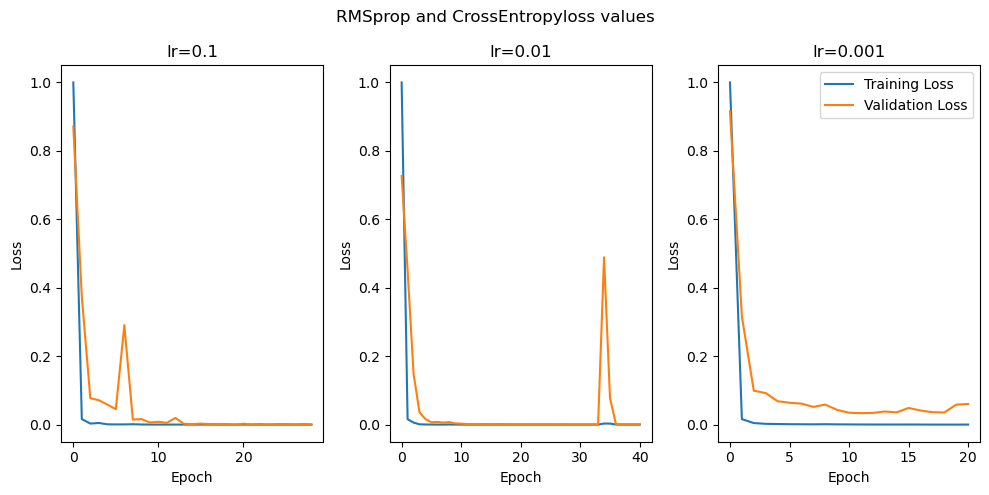

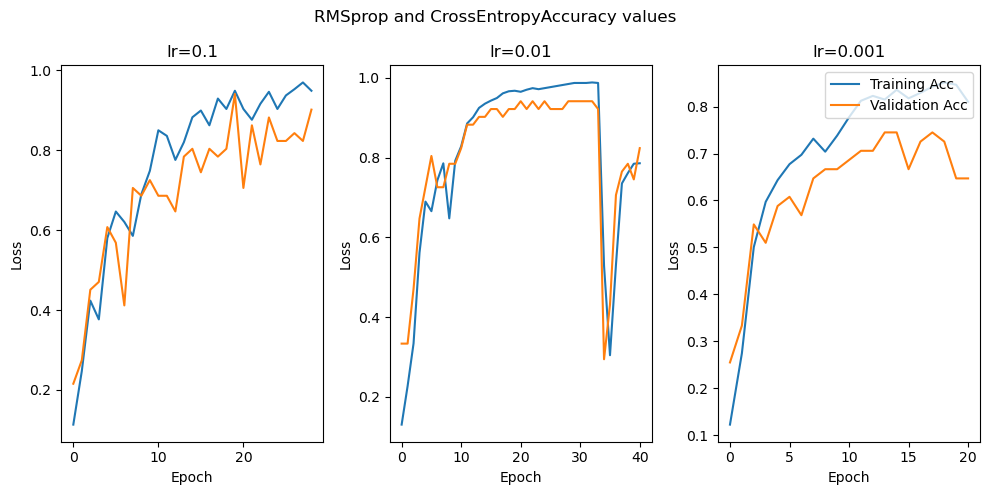

In [42]:
hidden_layer_sizes_1 = ((num_inputs + num_classes) // 2,)*1
train_val_model_ev_best_optmizer(MLP, num_inputs_dos, hidden_layer_sizes_1, num_classes, X_train_flattened_ovs, y_train_fl_ovs, X_val_flattened, y_val_fl, criterion_CrossEntropy, 'RMSprop', 50, 'RMSprop and CrossEntropy', patience=10)

RMSprop and CrossEntropy w/ lr= 0.1
Epoch [1/50], Train Loss: 4105648.1221, Val Loss: 42580.0547, Train Acc: 0.1237, Val Acc: 0.2549
Epoch [2/50], Train Loss: 21851.5626, Val Loss: 4064.5325, Train Acc: 0.2516, Val Acc: 0.2941
Epoch [3/50], Train Loss: 2065.3969, Val Loss: 437.2698, Train Acc: 0.4518, Val Acc: 0.6863
Epoch [4/50], Train Loss: 642.2296, Val Loss: 308.1251, Train Acc: 0.5628, Val Acc: 0.7843
Epoch [5/50], Train Loss: 428.3139, Val Loss: 410.7042, Train Acc: 0.6211, Val Acc: 0.6275
Epoch [6/50], Train Loss: 238.5180, Val Loss: 90.4367, Train Acc: 0.7108, Val Acc: 0.8431
Epoch [7/50], Train Loss: 129.1201, Val Loss: 152.8776, Train Acc: 0.6928, Val Acc: 0.7647
Epoch [8/50], Train Loss: 103.3353, Val Loss: 83.9318, Train Acc: 0.7699, Val Acc: 0.8627
Epoch [9/50], Train Loss: 215.9975, Val Loss: 336.1311, Train Acc: 0.6995, Val Acc: 0.7255
Epoch [10/50], Train Loss: 218.1568, Val Loss: 51.6029, Train Acc: 0.6893, Val Acc: 0.7843
Epoch [11/50], Train Loss: 80.3285, Val Loss: 

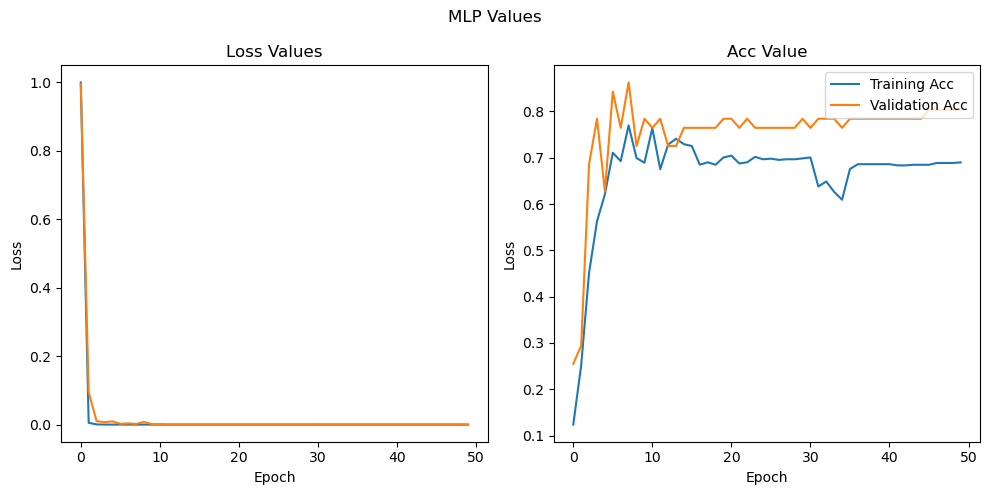

Evaluating with the Training data
Confusion Matrix:
 [[67  0  0  0 17  0  0  0  0]
 [ 0 68  0  0 16  0  0  0  0]
 [ 0  0 84  0  0  0  0  0  0]
 [ 0  0  0 68 16  0  0  0  0]
 [ 0  0  0  0 78  0  0  6  0]
 [ 0  0  0  0 54 30  0  0  0]
 [ 0  0  0  0 61  0 23  0  0]
 [ 0  0  0  0 52  0  0 32  0]
 [ 0  0  0  0  8  0  0  0 76]]
F1 Score:  0.7235387195486629
Accuracy:  0.6957671957671958
Precison:  0.9000426009836954
Evaluating with the Validation data
Confusion Matrix:
 [[10  0  0  0  2  0  0  0  0]
 [ 0  4  0  0  1  0  0  0  1]
 [ 0  0  7  0  0  0  0  0  0]
 [ 0  0  0  3  0  0  0  0  0]
 [ 0  0  0  0  2  0  0  0  0]
 [ 0  0  0  0  2  2  0  0  0]
 [ 0  0  0  0  1  0  1  0  0]
 [ 0  0  0  0  1  0  0  1  0]
 [ 0  1  0  0  1  0  0  0 11]]
F1 Score:  0.8375044563279858
Accuracy:  0.803921568627451
Precison:  0.9238562091503268


In [47]:
# lr = 0.1
model_rms_ce_dos_2 = train_val_model_ev(MLP, num_inputs_dos, hidden_layer_sizes_1, num_classes, X_train_flattened_ovs, y_train_fl_ovs, X_val_flattened, y_val_fl, criterion_CrossEntropy, 'RMSprop', 50, 'RMSprop and CrossEntropy',0.1, patience=15)

In [51]:
print('Evaluating with the Test data')
evaluate_network(model_rms_ce_dos_2, X_test_fl, y_test_fl)

Evaluating with the Test data
Confusion Matrix:
 [[11  0  0  0  1  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  1]
 [ 0  0  9  0  0  0  0  0  0]
 [ 0  0  0  3  2  0  0  0  0]
 [ 0  0  0  0  2  0  0  0  0]
 [ 0  0  0  0  3  0  0  0  0]
 [ 0  0  0  0  3  0  0  0  0]
 [ 0  0  0  0  4  0  0  5  0]
 [ 0  1  0  0  0  0  0  0  6]]
F1 Score:  0.7382532176119012
Accuracy:  0.7169811320754716
Precison:  0.8163522012578616


c:\Users\davic\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RMSprop and CrossEntropy w/ lr= 0.001
Epoch [1/50], Train Loss: 538.8690, Val Loss: 22.8814, Train Acc: 0.1029, Val Acc: 0.3333
Epoch [2/50], Train Loss: 5.0350, Val Loss: 2.4220, Train Acc: 0.3558, Val Acc: 0.4706
Epoch [3/50], Train Loss: 1.5297, Val Loss: 1.6095, Train Acc: 0.5370, Val Acc: 0.5294
Epoch [4/50], Train Loss: 1.1485, Val Loss: 1.0992, Train Acc: 0.5991, Val Acc: 0.7451
Epoch [5/50], Train Loss: 1.0530, Val Loss: 1.1846, Train Acc: 0.6281, Val Acc: 0.7451
Epoch [6/50], Train Loss: 0.7964, Val Loss: 0.9260, Train Acc: 0.6929, Val Acc: 0.7451
Epoch [7/50], Train Loss: 0.7482, Val Loss: 1.3225, Train Acc: 0.6946, Val Acc: 0.5294
Epoch [8/50], Train Loss: 0.7235, Val Loss: 0.8108, Train Acc: 0.6896, Val Acc: 0.7843
Epoch [9/50], Train Loss: 0.6270, Val Loss: 1.0391, Train Acc: 0.7485, Val Acc: 0.7059
Epoch [10/50], Train Loss: 0.6318, Val Loss: 0.7952, Train Acc: 0.7339, Val Acc: 0.8039
Epoch [11/50], Train Loss: 0.5850, Val Loss: 0.6378, Train Acc: 0.7628, Val Acc: 0.8039


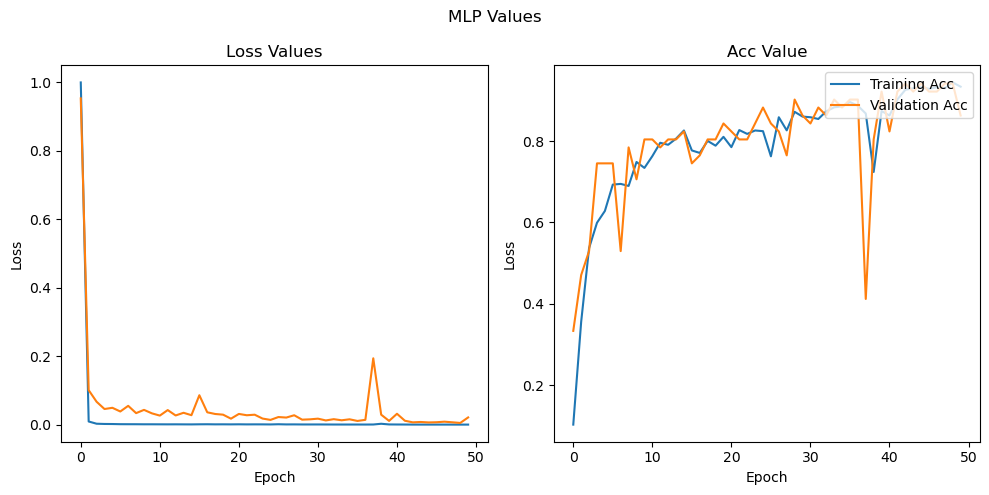

Evaluating with the Training data
Confusion Matrix:
 [[84  0  0  0  0  0  0  0  0]
 [ 0 84  0  0  0  0  0  0  0]
 [ 0  0 82  0  0  0  2  0  0]
 [ 0  0  0 50  0  0 34  0  0]
 [ 0  0  0  0  0  0 82  2  0]
 [ 0  0  0  0  0  0 84  0  0]
 [ 0  0  0  0  0  0 84  0  0]
 [ 0  0  0  0  0  0  0 84  0]
 [ 0  0  0  0  0  0  0  0 84]]
F1 Score:  0.6862788680130039
Accuracy:  0.7301587301587301
Precison:  0.6967167199725338
Evaluating with the Validation data
Confusion Matrix:
 [[12  0  0  0  0  0  0  0  0]
 [ 0  5  0  0  0  0  0  0  1]
 [ 0  0  7  0  0  0  0  0  0]
 [ 0  0  0  3  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  1  0]
 [ 0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0 13]]
F1 Score:  0.8325873110186836
Accuracy:  0.8627450980392157
Precison:  0.823062558356676


c:\Users\davic\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\davic\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
# lr = 0.001
model_rms_ce_ds_1 = train_val_model_ev(MLP, num_inputs_dos, hidden_layer_sizes_1, num_classes, X_train_flattened_ovs, y_train_fl_ovs, X_val_flattened, y_val_fl, criterion_CrossEntropy, 'RMSprop', 50, 'RMSprop and CrossEntropy',0.001, patience=15)

In [53]:
print('Evaluating with the Test data')
evaluate_network(model_rms_ce_ds_1, X_test_fl, y_test_fl)

Evaluating with the Test data
Confusion Matrix:
 [[12  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  1]
 [ 0  0  9  0  0  0  0  0  0]
 [ 0  0  0  2  0  0  3  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  0  9  0]
 [ 0  0  0  0  0  0  0  0  7]]
F1 Score:  0.8127583108715184
Accuracy:  0.8301886792452831
Precison:  0.8479845626072041


c:\Users\davic\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RMSprop and CrossEntropy w/ lr=0.1
Epoch [1/50], Train Loss: 1887313687.2904, Val Loss: 21850966.0000, Train Acc: 0.1136, Val Acc: 0.0588
Epoch [2/50], Train Loss: 20666322.3864, Val Loss: 2398506.7500, Train Acc: 0.0958, Val Acc: 0.1373
Epoch [3/50], Train Loss: 1003211.8977, Val Loss: 282170.0312, Train Acc: 0.2833, Val Acc: 0.4902
Epoch [4/50], Train Loss: 40791.9420, Val Loss: 83010.6406, Train Acc: 0.3939, Val Acc: 0.4706
Epoch [5/50], Train Loss: 7358.3252, Val Loss: 295.5240, Train Acc: 0.5447, Val Acc: 0.6863
Epoch [6/50], Train Loss: 18717.9851, Val Loss: 2113.0071, Train Acc: 0.4792, Val Acc: 0.6078
Epoch [7/50], Train Loss: 376.6051, Val Loss: 268.7386, Train Acc: 0.4167, Val Acc: 0.6078
Epoch [8/50], Train Loss: 93.2287, Val Loss: 121.1947, Train Acc: 0.4337, Val Acc: 0.6667
Epoch [9/50], Train Loss: 54.4853, Val Loss: 46.1840, Train Acc: 0.4607, Val Acc: 0.6667
Epoch [10/50], Train Loss: 46.4115, Val Loss: 25.7468, Train Acc: 0.5191, Val Acc: 0.6471
Epoch [11/50], Train Lo

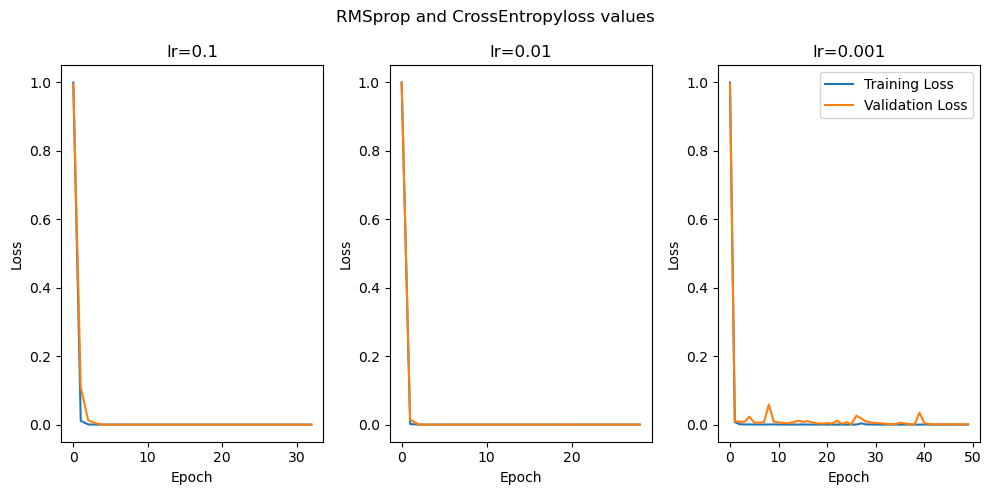

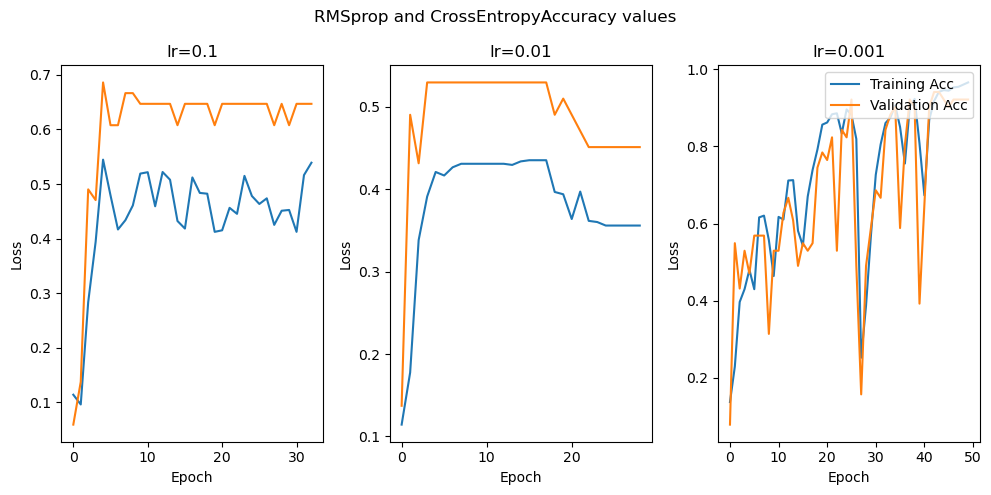

In [47]:
hidden_layer_sizes_2 = ((num_inputs + num_classes) // 2,)*2
train_val_model_ev_best_optmizer(MLP, num_inputs_dos, hidden_layer_sizes_2, num_classes, X_train_flattened_ovs, y_train_fl_ovs, X_val_flattened, y_val_fl, criterion_CrossEntropy, 'RMSprop', 50, 'RMSprop and CrossEntropy', patience=15)

RMSprop and CrossEntropy w/ lr= 0.001
Epoch [1/50], Train Loss: 3254.3373, Val Loss: 80.1005, Train Acc: 0.1071, Val Acc: 0.0784
Epoch [2/50], Train Loss: 26.9848, Val Loss: 6.4422, Train Acc: 0.1341, Val Acc: 0.1373
Epoch [3/50], Train Loss: 2.5533, Val Loss: 1.4569, Train Acc: 0.3569, Val Acc: 0.5686
Epoch [4/50], Train Loss: 1.5435, Val Loss: 2.4836, Train Acc: 0.5003, Val Acc: 0.3725
Epoch [5/50], Train Loss: 1.3678, Val Loss: 1.1695, Train Acc: 0.5595, Val Acc: 0.6275
Epoch [6/50], Train Loss: 1.6745, Val Loss: 7.0127, Train Acc: 0.5526, Val Acc: 0.3333
Epoch [7/50], Train Loss: 2.5257, Val Loss: 2.1080, Train Acc: 0.4466, Val Acc: 0.5686
Epoch [8/50], Train Loss: 1.5315, Val Loss: 2.8430, Train Acc: 0.5432, Val Acc: 0.4902
Epoch [9/50], Train Loss: 1.5306, Val Loss: 3.0443, Train Acc: 0.5842, Val Acc: 0.4902
Epoch [10/50], Train Loss: 1.4837, Val Loss: 2.8312, Train Acc: 0.5475, Val Acc: 0.4902
Epoch [11/50], Train Loss: 1.2174, Val Loss: 1.5674, Train Acc: 0.6288, Val Acc: 0.588

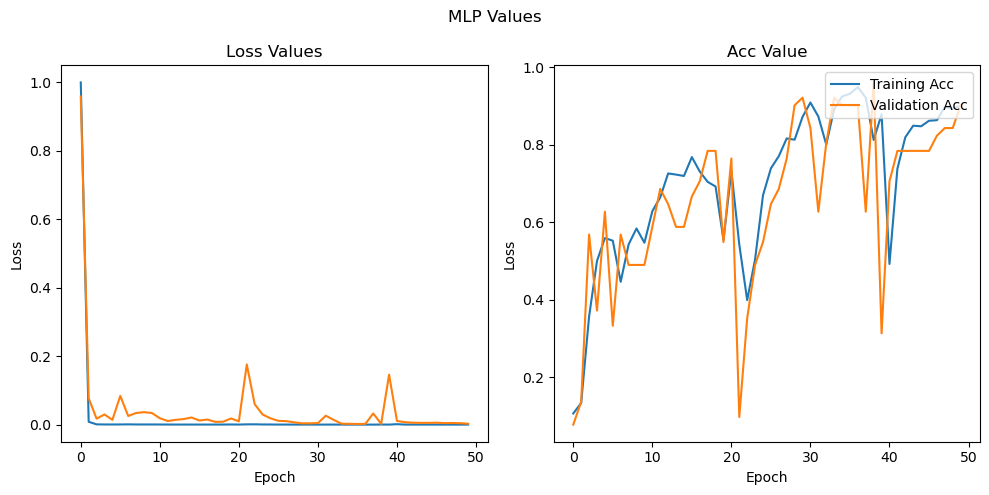

Evaluating with the Training data
Confusion Matrix:
 [[78  0  0  0  0  0  0  0  0]
 [ 0 78  0  0  0  0  0  0  0]
 [ 0  0 78  0  0  0  0  0  0]
 [ 0  0  0 44  0 34  0  0  0]
 [ 0  0  0  0 46  0 32  0  0]
 [ 0  0  0  0  0 74  4  0  0]
 [ 0  0  0  0  0  1 77  0  0]
 [ 0  0  0  0  0  0  0 78  0]
 [ 0  0  0  0  0  0  0  0 78]]
F1 Score:  0.8956637257845858
Accuracy:  0.8988603988603988
Precison:  0.9289238901969274
Evaluating with the Validation data
Confusion Matrix:
 [[ 9  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0]
 [ 0  0 12  0  0  0  0  0  0]
 [ 0  0  0  7  0  2  0  0  0]
 [ 0  0  0  0  0  1  1  0  0]
 [ 0  0  0  0  0  4  0  0  0]
 [ 0  0  0  0  0  1  2  0  0]
 [ 0  0  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  0  0  7]]
F1 Score:  0.8929738562091503
Accuracy:  0.9019607843137255
Precison:  0.9019607843137255
Evaluating with the Test data
Confusion Matrix:
 [[12  0  0  0  0  0  0  0  0]
 [ 0  5  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0]
 [ 0  0  0  1  0  1  0  0  0]
 

c:\Users\davic\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
model_rms_ce_ds_2 = train_val_model_ev(MLP, num_inputs_dos, hidden_layer_sizes_2, num_classes, X_train_flattened_ovs, y_train_fl_ovs, X_val_flattened, y_val_fl, criterion_CrossEntropy, 'RMSprop', 50, 'RMSprop and CrossEntropy',0.001, patience=15)
print('Evaluating with the Test data')
evaluate_network(model_rms_ce_ds_2, X_test_fl, y_test_fl)

In [52]:
model_rms_ce_ds_2 = train_val_model_ev(MLP, num_inputs_dos, hidden_layer_sizes_2, num_classes, X_train_flattened_ovs, y_train_fl_ovs, X_val_flattened, y_val_fl, criterion_CrossEntropy, 'RMSprop', 50, 'RMSprop and CrossEntropy',0.01, patience=15)
print('Evaluating with the Test data')
evaluate_network(model_rms_ce_ds_2, X_test_fl, y_test_fl)

RMSprop and CrossEntropy w/ lr= 0.01
Epoch [1/50], Train Loss: 2125528.5039, Val Loss: 6150.3022, Train Acc: 0.0938, Val Acc: 0.0784
Epoch [2/50], Train Loss: 20489.4543, Val Loss: 4970.2354, Train Acc: 0.1654, Val Acc: 0.3725
Epoch [3/50], Train Loss: 1983.0931, Val Loss: 304.5004, Train Acc: 0.1975, Val Acc: 0.4118
Epoch [4/50], Train Loss: 123.2548, Val Loss: 49.0838, Train Acc: 0.3453, Val Acc: 0.4314
Epoch [5/50], Train Loss: 21.1601, Val Loss: 2.8181, Train Acc: 0.4638, Val Acc: 0.6078
Epoch [6/50], Train Loss: 3.3961, Val Loss: 5.9536, Train Acc: 0.5006, Val Acc: 0.6275
Epoch [7/50], Train Loss: 1.9719, Val Loss: 1.2968, Train Acc: 0.4876, Val Acc: 0.6471
Epoch [8/50], Train Loss: 1.3033, Val Loss: 1.1984, Train Acc: 0.5159, Val Acc: 0.6471
Epoch [9/50], Train Loss: 1.3020, Val Loss: 1.2050, Train Acc: 0.5048, Val Acc: 0.6667
Epoch [10/50], Train Loss: 1.2243, Val Loss: 1.1626, Train Acc: 0.5148, Val Acc: 0.6667
Epoch [11/50], Train Loss: 1.2919, Val Loss: 1.1000, Train Acc: 0.5

KeyboardInterrupt: 

###### **Class Weighting RMSprop and CrossEntropy**

RMSprop and CrossEntropy w/ lr=0.1
Epoch [1/30], Train Loss: 11486847.9141, Val Loss: 6.7131, Train Acc: 0.1067, Val Acc: 0.2745
Epoch [2/30], Train Loss: 3.3448, Val Loss: 2.2844, Train Acc: 0.1163, Val Acc: 0.0392
Epoch [3/30], Train Loss: 2.2841, Val Loss: 2.2388, Train Acc: 0.1260, Val Acc: 0.0392
Epoch [4/30], Train Loss: 2.2742, Val Loss: 2.2426, Train Acc: 0.1260, Val Acc: 0.0392
Epoch [5/30], Train Loss: 2.2724, Val Loss: 2.2469, Train Acc: 0.1260, Val Acc: 0.0392
Epoch [6/30], Train Loss: 2.2676, Val Loss: 2.2312, Train Acc: 0.1260, Val Acc: 0.0392
Epoch [7/30], Train Loss: 2.2575, Val Loss: 2.2308, Train Acc: 0.1212, Val Acc: 0.0392
Epoch [8/30], Train Loss: 2.2582, Val Loss: 2.2345, Train Acc: 0.1187, Val Acc: 0.0392
Epoch [9/30], Train Loss: 2.2539, Val Loss: 2.1963, Train Acc: 0.1163, Val Acc: 0.0980
Epoch [10/30], Train Loss: 2.2491, Val Loss: 2.2033, Train Acc: 0.1260, Val Acc: 0.0392
Epoch [11/30], Train Loss: 2.2502, Val Loss: 2.2056, Train Acc: 0.1163, Val Acc: 0.0392

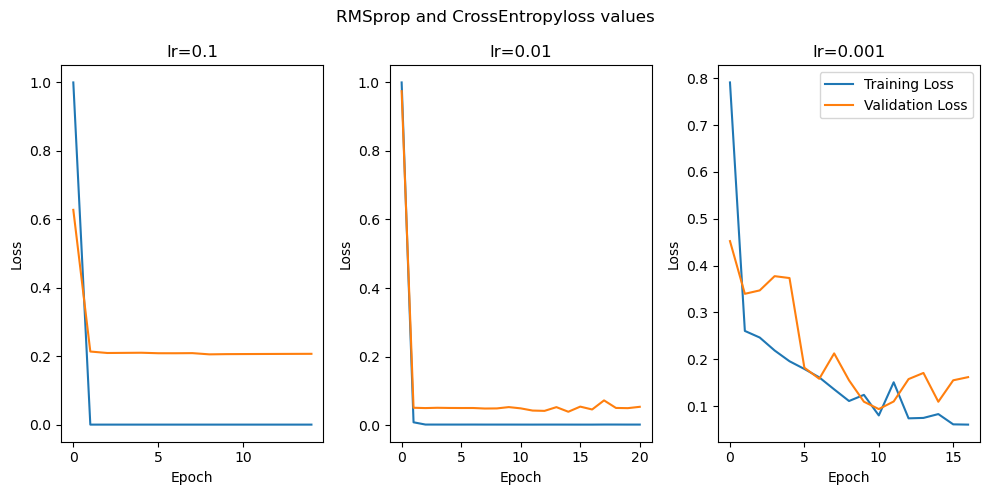

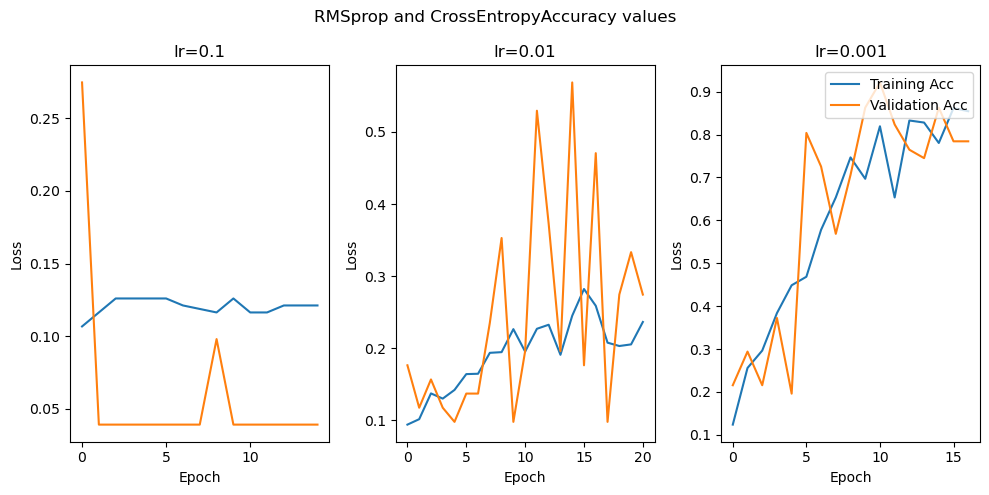

In [86]:
train_val_model_ev_best_optmizer(MLP, num_inputs, hidden_layer_sizes, num_classes, X_train_flattened, y_train_fl, X_val_flattened, y_val_fl, criterion_CrossEntropy_classWeight, 'RMSprop', n_epochs, 'RMSprop and CrossEntropy')

In [ ]:
# The lr = 0.01 show a good balance between the both loss values. This suggest that the model is generalizing well to unseen data
# The lr = 0.1 don't shows a bit of underfitting.
# The lr = 0.001 indicates a underfitting.

RMSprop and CrossEntropy w/ lr= 0.01
Epoch [1/30], Train Loss: 41519.9564, Val Loss: 2346.7559, Train Acc: 0.1620, Val Acc: 0.3529
Epoch [2/30], Train Loss: 883.6233, Val Loss: 137.7214, Train Acc: 0.3409, Val Acc: 0.5686
Epoch [3/30], Train Loss: 67.8672, Val Loss: 21.3922, Train Acc: 0.6957, Val Acc: 0.8039
Epoch [4/30], Train Loss: 28.2563, Val Loss: 22.6409, Train Acc: 0.7389, Val Acc: 0.8039
Epoch [5/30], Train Loss: 14.3377, Val Loss: 18.1062, Train Acc: 0.8192, Val Acc: 0.9020
Epoch [6/30], Train Loss: 8.8147, Val Loss: 32.3513, Train Acc: 0.8503, Val Acc: 0.7255
Epoch [7/30], Train Loss: 12.6625, Val Loss: 8.8132, Train Acc: 0.8171, Val Acc: 0.9020
Epoch [8/30], Train Loss: 7.4351, Val Loss: 24.7214, Train Acc: 0.8619, Val Acc: 0.7451
Epoch [9/30], Train Loss: 7.4178, Val Loss: 7.6677, Train Acc: 0.8479, Val Acc: 0.8235
Epoch [10/30], Train Loss: 5.5266, Val Loss: 7.4369, Train Acc: 0.8792, Val Acc: 0.8235
Epoch [11/30], Train Loss: 6.1580, Val Loss: 15.4954, Train Acc: 0.8766,

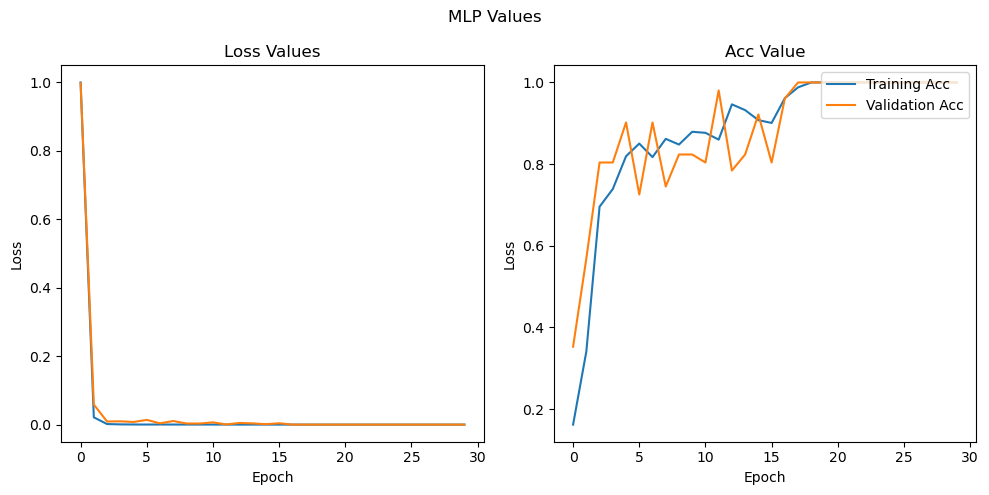

Evaluating with the Training data
Confusion Matrix:
 [[69  0  0  0  0  0  0  0  0]
 [ 0 30  0  0  0  0  0  0  0]
 [ 0  0 71  0  0  0  0  0  0]
 [ 0  0  0 52  0  0  0  0  0]
 [ 0  0  0  0 27  0  0  0  0]
 [ 0  0  0  0  0 27  0  0  0]
 [ 0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 63]]
F1 Score:  1.0
Accuracy:  1.0
Precison:  1.0
Evaluating with the Validation data
Confusion Matrix:
 [[ 9  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0]
 [ 0  0 14  0  0  0  0  0  0]
 [ 0  0  0  5  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  0  5  0]
 [ 0  0  0  0  0  0  0  0 10]]
F1 Score:  1.0
Accuracy:  1.0
Precison:  1.0


In [72]:
# lr = 0.01
model_rms_ce_cw = train_val_model_ev(MLP, num_inputs, hidden_layer_sizes, num_classes, X_train_flattened, y_train_fl, X_val_flattened, y_val_fl, criterion_CrossEntropy_classWeight, 'RMSprop', n_epochs, 'RMSprop and CrossEntropy',0.01)

###### **Data Oversampling RMSprop and MSE**

RMSprop and MSE w/ lr=0.1
Epoch [1/30], Train Loss: 490745493131995.6875, Val Loss: 3772.8962
Epoch [2/30], Train Loss: 39874.8079, Val Loss: 3766.6956
Epoch [3/30], Train Loss: 39804.8067, Val Loss: 3757.7701
Epoch [4/30], Train Loss: 39637.4555, Val Loss: 3736.2672
Epoch [5/30], Train Loss: 39392.1855, Val Loss: 3711.3960
Epoch [6/30], Train Loss: 39103.1425, Val Loss: 3681.4609
Epoch [7/30], Train Loss: 38747.1112, Val Loss: 3643.6531
Epoch [8/30], Train Loss: 38285.3030, Val Loss: 3593.2291
Epoch [9/30], Train Loss: 37651.5350, Val Loss: 3522.0194
Epoch [10/30], Train Loss: 36730.7507, Val Loss: 3415.7133
Epoch [11/30], Train Loss: 35321.1556, Val Loss: 3249.2773
Epoch [12/30], Train Loss: 33075.8876, Val Loss: 2980.7632
Epoch [13/30], Train Loss: 29450.8454, Val Loss: 2550.0232
Epoch [14/30], Train Loss: 23816.2881, Val Loss: 1909.0943
Epoch [15/30], Train Loss: 16138.4296, Val Loss: 1126.4818
Epoch [16/30], Train Loss: 8190.4053, Val Loss: 466.4877
Epoch [17/30], Train Loss: 2867

c:\Users\davic\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\davic\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([25])) that is different to the input size (torch.Size([25, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\davic\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([19, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_lo

Epoch [1/30], Train Loss: 56163855382.8982, Val Loss: 3318.8345
Epoch [2/30], Train Loss: 31495.9692, Val Loss: 2116.6874
Epoch [3/30], Train Loss: 4479.8292, Val Loss: 48.9491
Epoch [4/30], Train Loss: 198.6822, Val Loss: 49.9326
Epoch [5/30], Train Loss: 192.0991, Val Loss: 50.7474
Epoch [6/30], Train Loss: 185.9588, Val Loss: 51.3752
Epoch [7/30], Train Loss: 180.3549, Val Loss: 51.8231
Epoch [8/30], Train Loss: 175.3980, Val Loss: 52.1117
Epoch [9/30], Train Loss: 171.2339, Val Loss: 52.2779
Epoch [10/30], Train Loss: 168.0831, Val Loss: 52.3771
Early stopping at epoch 10!
RMSprop and MSE w/ lr=0.001


c:\Users\davic\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\davic\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([25])) that is different to the input size (torch.Size([25, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\davic\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([19, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_lo

Epoch [1/30], Train Loss: 12148408.1328, Val Loss: 47.2304
Epoch [2/30], Train Loss: 191.9297, Val Loss: 48.0787
Epoch [3/30], Train Loss: 183.9128, Val Loss: 48.3147
Epoch [4/30], Train Loss: 177.4320, Val Loss: 48.5378
Epoch [5/30], Train Loss: 171.9063, Val Loss: 48.8223
Epoch [6/30], Train Loss: 167.0667, Val Loss: 49.6190
Epoch [7/30], Train Loss: 163.2590, Val Loss: 49.7606
Epoch [8/30], Train Loss: 160.1835, Val Loss: 50.2316
Early stopping at epoch 8!


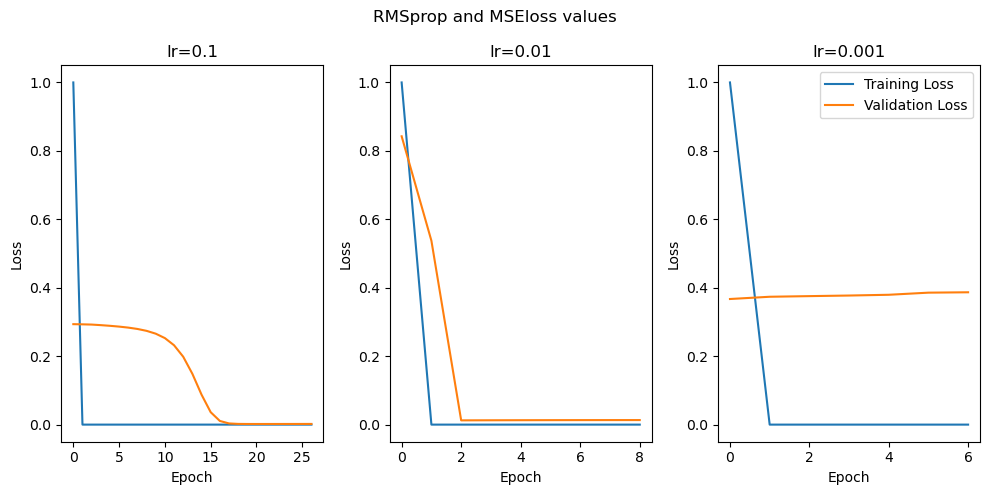

In [76]:
train_val_model_ev_best_optmizer(MLP2, num_inputs_dos, hidden_layer_sizes_dos, num_classes, X_train_flattened_ovs, y_train_fl_ovs, X_val_flattened, y_val_fl, criterion_MSE, 'RMSprop', n_epochs, 'RMSprop and MSE')

In [ ]:
# This shows that using MSE might not be the most optimal approach

###### **Data Oversampling Adam and CrossEntropy**

Adam and CrossEntropy w/ lr=0.1
Epoch [1/30], Train Loss: 25552.8976, Val Loss: 384.2868, Train Acc: 0.0635, Val Acc: 0.1961
Epoch [2/30], Train Loss: 81.0261, Val Loss: 6.6782, Train Acc: 0.2092, Val Acc: 0.1961
Epoch [3/30], Train Loss: 1.3441, Val Loss: 2.0450, Train Acc: 0.1042, Val Acc: 0.1961
Epoch [4/30], Train Loss: 1.3139, Val Loss: 1.9191, Train Acc: 0.0801, Val Acc: 0.1961
Epoch [5/30], Train Loss: 1.2675, Val Loss: 1.8353, Train Acc: 0.0781, Val Acc: 0.2157
Epoch [6/30], Train Loss: 1.2673, Val Loss: 1.9223, Train Acc: 0.0889, Val Acc: 0.1765
Epoch [7/30], Train Loss: 1.2837, Val Loss: 1.9102, Train Acc: 0.0693, Val Acc: 0.1765
Epoch [8/30], Train Loss: 1.2940, Val Loss: 1.8963, Train Acc: 0.0654, Val Acc: 0.1765
Epoch [9/30], Train Loss: 1.2936, Val Loss: 1.8930, Train Acc: 0.0654, Val Acc: 0.1765
Epoch [10/30], Train Loss: 1.2936, Val Loss: 1.8941, Train Acc: 0.0654, Val Acc: 0.1765
Epoch [11/30], Train Loss: 1.2939, Val Loss: 1.8949, Train Acc: 0.0654, Val Acc: 0.1765
Ep

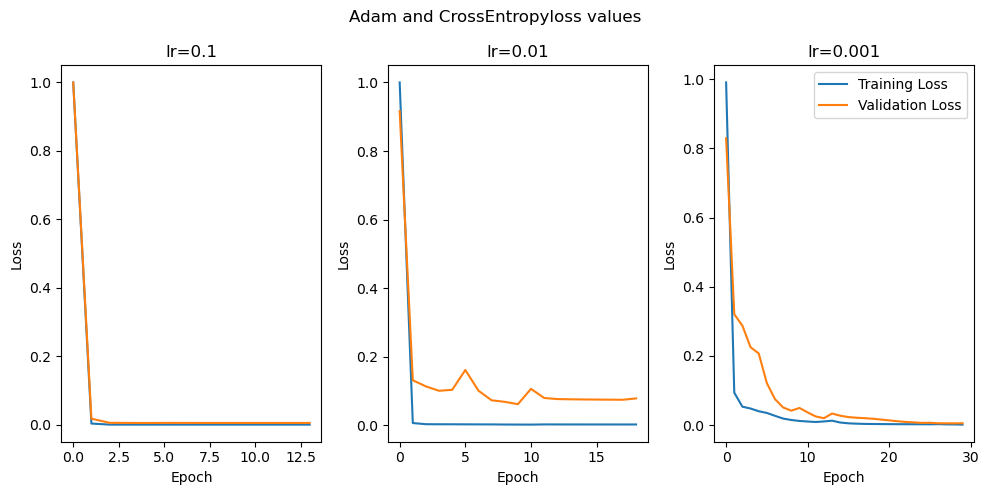

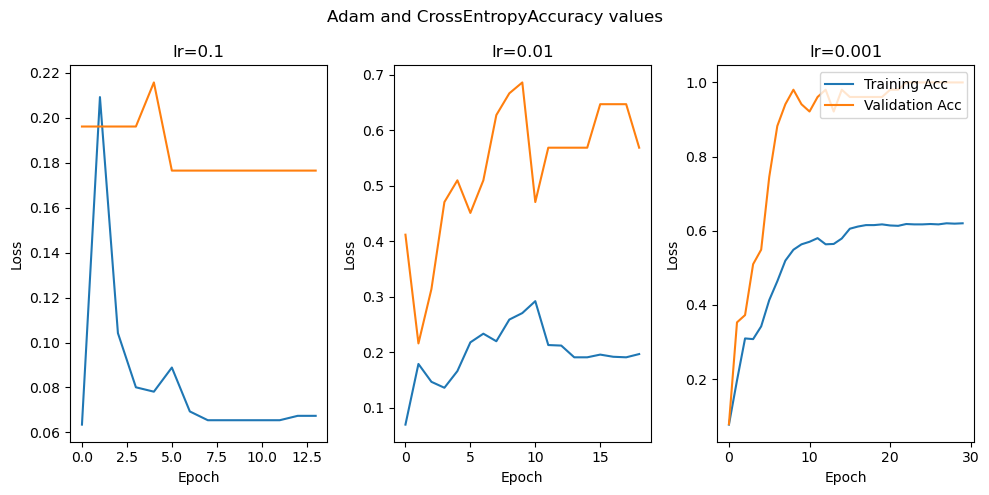

In [64]:
train_val_model_ev_best_optmizer(MLP, num_inputs_dos, hidden_layer_sizes_dos, num_classes, X_train_flattened_ovs, y_train_fl_ovs, X_val_flattened, y_val_fl, criterion_CrossEntropy, 'Adam', n_epochs, 'Adam and CrossEntropy', patience=10)

Adam and CrossEntropy w/ lr= 0.001
Epoch [1/30], Train Loss: 17.2371, Val Loss: 2.8238, Train Acc: 0.0861, Val Acc: 0.2549
Epoch [2/30], Train Loss: 1.4825, Val Loss: 2.7215, Train Acc: 0.1777, Val Acc: 0.0980
Epoch [3/30], Train Loss: 1.1172, Val Loss: 1.2496, Train Acc: 0.2365, Val Acc: 0.5294
Epoch [4/30], Train Loss: 0.7502, Val Loss: 1.3008, Train Acc: 0.3604, Val Acc: 0.3922
Epoch [5/30], Train Loss: 0.6609, Val Loss: 0.8858, Train Acc: 0.3919, Val Acc: 0.5490
Epoch [6/30], Train Loss: 0.4735, Val Loss: 0.5433, Train Acc: 0.4658, Val Acc: 0.8235
Epoch [7/30], Train Loss: 0.3679, Val Loss: 0.2735, Train Acc: 0.5088, Val Acc: 0.9608
Epoch [8/30], Train Loss: 0.3251, Val Loss: 0.2666, Train Acc: 0.5253, Val Acc: 0.9216
Epoch [9/30], Train Loss: 0.2511, Val Loss: 0.3074, Train Acc: 0.5478, Val Acc: 0.8235
Epoch [10/30], Train Loss: 0.2156, Val Loss: 0.2413, Train Acc: 0.5644, Val Acc: 0.9020
Epoch [11/30], Train Loss: 0.1631, Val Loss: 0.1905, Train Acc: 0.5791, Val Acc: 0.9020
Epoch

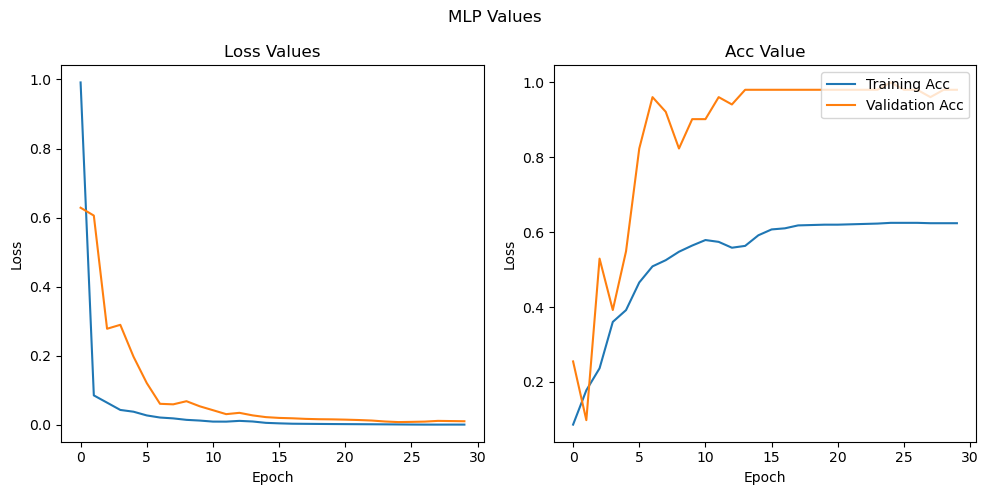

Evaluating with the Training data
Confusion Matrix:
 [[71  0  0  0  0  0  0  0  0]
 [ 0 71  0  0  0  0  0  0  0]
 [ 0  0 71  0  0  0  0  0  0]
 [ 0  0  0 70  0  1  0  0  0]
 [ 0  0  0  0 71  0  0  0  0]
 [ 0  0  0  0  0 71  0  0  0]
 [ 0  0  0  0  0  0 71  0  0]
 [ 0  0  0  0  0  0  0 71  0]
 [ 0  0  0  0  0  0  0  0 71]]
F1 Score:  0.9984349771583814
Accuracy:  0.9984350547730829
Precison:  0.9984567901234568
Evaluating with the Validation data
Confusion Matrix:
 [[ 9  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0]
 [ 0  0 14  0  0  0  0  0  0]
 [ 0  0  0  4  0  1  0  0  0]
 [ 0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  0  5  0]
 [ 0  0  0  0  0  0  0  0 10]]
F1 Score:  0.9812636165577342
Accuracy:  0.9803921568627451
Precison:  0.9869281045751633


In [63]:
# lr = 0.001
model_rms_ce_cw = train_val_model_ev(MLP, num_inputs_dos, hidden_layer_sizes_dos, num_classes, X_train_flattened_ovs, y_train_fl_ovs, X_val_flattened, y_val_fl, criterion_CrossEntropy, 'Adam', n_epochs, 'Adam and CrossEntropy',0.001, patience=10)